# Round trip time box plots

For each scenario get all successful calls and divide data on clientIDs i.e. db.calls.find({"scenario_type": "1","client_username": "d1_Normal", "state": "call_ended"})

For all the client ids, find all the reports data where it's either RemoteInbound or RemoteOutbound RTT. Add this data field to the data frame of the given scenario and client type (Alice or Bob).

In [1]:
import sys
from dotenv import load_dotenv
from datetime import datetime, timedelta
import pandas as pd
import os
import json
import logging
import matplotlib.pyplot as plt
from helperFunctions import getScenarioLabels

logging.basicConfig(
  format=f'%(asctime)s %(levelname)-8s %(message)s ',
  level=logging.INFO,
  datefmt='%Y-%m-%d %H:%M:%S',
  handlers=[
  logging.StreamHandler(sys.stdout)
  ])

callAndOutcomeFile = "output_folder/UniqueCallsAndOutcomes.csv"
outputFolder = "output_folder/"


if not os.path.exists(outputFolder):

   # Create a new directory because it does not exist
   os.makedirs(outputFolder)
   logging.info(f"The directory \"{outputFolder}\" is created!")

In [2]:
plotDf = pd.DataFrame(columns=["scenario", "client", "RTT"])

callsDf = pd.read_csv(callAndOutcomeFile)

logging.info(f"shape of calls: {callsDf.shape}")

# filter for calls with state success
successCallsDf = callsDf.loc[callsDf["logging_type"] == "COMMAND_SESSION_SUCCESS"]

logging.info(f"shape of success full calls: {successCallsDf.shape}")

scenarios = [
  {
    "scenario": 1,
    "alice": "c1-Normal",
    "bob": "d1-Normal"
  },{
    "scenario": 2,
    "alice": "c2-TorNormal",
    "bob": "d2-TorNormal"
  },{
    "scenario": 3,
    "alice": "c3-TorEurope",
    "bob": "d3-TorEurope"
  }
]

for scenario in scenarios:
  logging.info(scenario)
  s = scenario["scenario"]
  a = scenario["alice"]
  b = scenario["bob"]
  logging.info(f"Starting on scenario {s}, alice: {a}, bob: {b}")

  # filter for calls with scenario_type s
  scenarioCallsDf = successCallsDf.loc[successCallsDf["scenario_type"] == s]

  # get list of room_ids in scenarioCallsDf
  roomIds = scenarioCallsDf["room_id"].unique()

  reportForClientA = pd.read_csv(f"output_folder/rawReport/{a}.csv")
  reportForClientA = reportForClientA[(reportForClientA["type"] == "remote-inbound-rtp") & (reportForClientA["roomId"].isin(roomIds)) & (reportForClientA["mediaType"] == "video") ]
  dataA = pd.DataFrame(columns=["scenario", "client", "RTT"]).assign(RTT=reportForClientA["roundTripTime"])
  dataA = dataA.assign(scenario=s, client=a)

  reportForClientB = pd.read_csv(f"output_folder/rawReport/{b}.csv")
  reportForClientB = reportForClientB[(reportForClientB["type"] == "remote-inbound-rtp") & (reportForClientB["roomId"].isin(roomIds)) & (reportForClientB["mediaType"] == "video") ]
  dataB = pd.DataFrame(columns=["scenario", "client", "RTT"]).assign(RTT=reportForClientB["roundTripTime"])
  dataB = dataB.assign(scenario=s, client=b)

  plotDf = pd.concat([plotDf, dataA, dataB], ignore_index=True)

logging.info(f"plotDf: {plotDf}")

# save plotDf to csv
plotDf.to_csv(f"{outputFolder}/plotDf.csv",index=False, header=True, encoding='utf-8', mode='w')


2023-01-26 15:06:05 INFO     shape of calls: (23513, 14) 
2023-01-26 15:06:05 INFO     shape of success full calls: (19064, 14) 
2023-01-26 15:06:05 INFO     {'scenario': 1, 'alice': 'c1-Normal', 'bob': 'd1-Normal'} 
2023-01-26 15:06:05 INFO     Starting on scenario 1, alice: c1-Normal, bob: d1-Normal 
2023-01-26 15:06:11 INFO     {'scenario': 2, 'alice': 'c2-TorNormal', 'bob': 'd2-TorNormal'} 
2023-01-26 15:06:11 INFO     Starting on scenario 2, alice: c2-TorNormal, bob: d2-TorNormal 
2023-01-26 15:06:15 INFO     {'scenario': 3, 'alice': 'c3-TorEurope', 'bob': 'd3-TorEurope'} 
2023-01-26 15:06:15 INFO     Starting on scenario 3, alice: c3-TorEurope, bob: d3-TorEurope 
2023-01-26 15:06:20 INFO     plotDf:       scenario        client    RTT
0            1     c1-Normal  0.032
1            1     c1-Normal  0.018
2            1     c1-Normal  0.021
3            1     c1-Normal  0.025
4            1     c1-Normal  0.017
...        ...           ...    ...
76688        3  d3-TorEurope  0.6

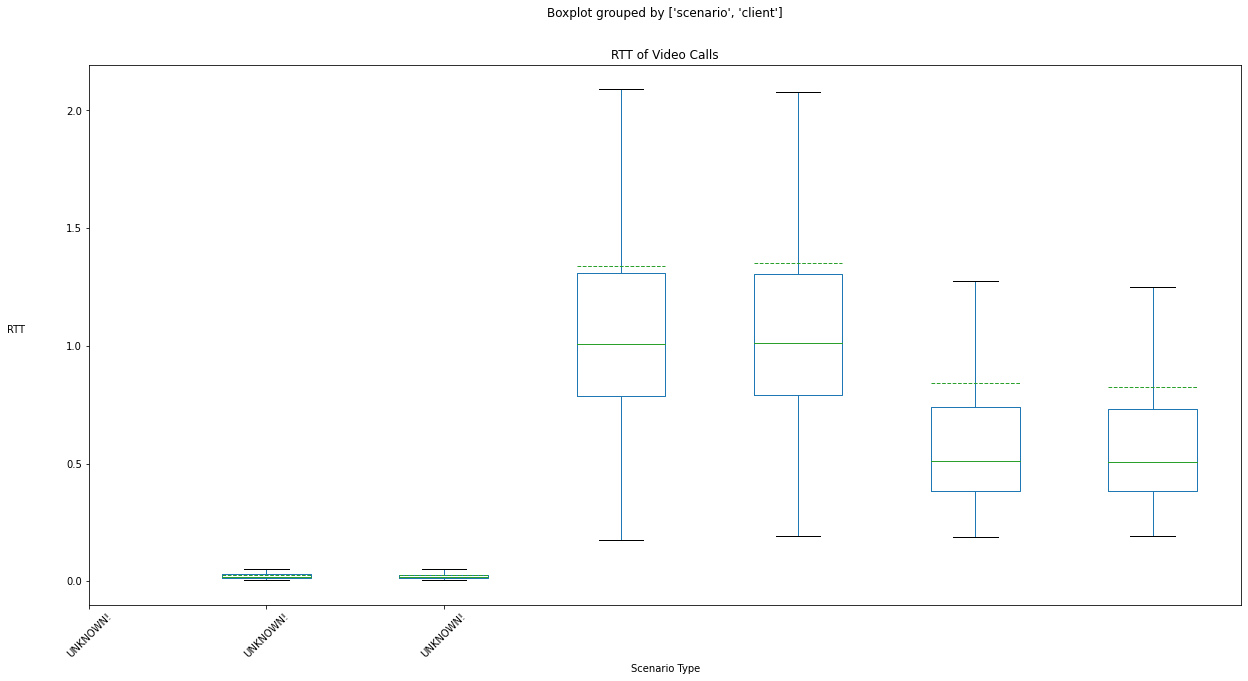

In [3]:
plotDf.boxplot(column="RTT", by=["scenario", "client"], grid=False, showmeans=True, meanline=True, showfliers=False, figsize=(20,10))
plt.title("RTT of Video Calls")
plt.xlabel("Scenario Type")
plt.ylabel("RTT", rotation=0, labelpad=50)

labels = getScenarioLabels(plotDf["scenario"].unique())
plt.xticks(range(len(labels)), labels, rotation=45, )
#plt.yticks(range(0, 100, 10))

# set size of plot
#plt.rcParams["figure.figsize"] = (20,5)

# set grid on x-axis in plot
#plt.grid(axis='y', linestyle='--', linewidth=0.5)


#plt.legend(fontsize=10)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


#plt.savefig("output_folder/SuccessOrFail.png", format="png", bbox_inches='tight', transparent=False, dpi=600, pad_inches=0.1, facecolor='w', edgecolor='w')
#plt.savefig("output_folder/SuccessOrFail.svg", format="svg", bbox_inches='tight', transparent=False, dpi=600, pad_inches=0.1, facecolor='w', edgecolor='w')
plt.show()